#### Flood Depth Prediction across the Contiguous United States using Multimodal Earth Observation Data and Machine Learning
This notebook shows the pipeline for training a machine learning model for predicting flood depths across the CONUS. 

### Datasets and Predictors
- [Digital Elevation Model at 10m and 1m](https://www.usgs.gov/3d-elevation-program)
- [National Land Cover Dataset Impervious Surfaces](https://www.usgs.gov/centers/eros/science/annual-national-land-cover-database)  
- [CHIRPS Precipitation](https://www.chc.ucsb.edu/data/chirps)
- [Sentinel 1 VV and VH](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD)
- [USGS High Water Mark Height](https://www.usgs.gov/water-science-school/science/high-water-marks-and-flooding)
- [Soil Moisture Active Passive](https://developers.google.com/earth-engine/tutorials/community/smap-soil-moisture)
- [Weather Parameters](https://www.weatherapi.com/)
    - Humidity 
    - Dewpoint Temperature
    - Wind Direction (UV)
    - Wind Gust (kPh)
    - Feels Like Temperature
    - Wind Chill
    - Heat Index
    - Chance of Rain
    - Chance of Snow
    - Visibiltiy (km)

Import necessary packages and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from utils import (split_dataset, 
                    z_normalize, 
                    calculate_regression_metrics, 
                    plot_actual_vs_predicted,
                    plot_residuals,
                    feature_importance_analysis,
                    plot_importances,
                    plot_cumulative_importances,
                    )

RANDOM_STATE=54

### Data Preparation
Load and prepare datasets for modelling

In [15]:
df_wlabs = pd.read_csv("data/combined_features.csv")
df = df_wlabs.drop(columns=['ID'])

X = df.drop(['height_above'], axis=1).select_dtypes(include=[np.number]).values
y = df['height_above'].values
indices = np.arange(len(X))
# np.random.shuffle(indices)
X = X[indices]
y = y[indices]

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")


Final feature matrix shape: (1147, 60)
Target variable shape: (1147,)


In [3]:
# split datasets in train, validation and test sets
X_train, y_train, X_val, y_val, X_test, y_test  = split_dataset(X, y, test_size=0.3, random_state=RANDOM_STATE)

Number of training observations: 802 (69.9%)
Number of validation observations: 172 (15.0%)
Number of test observations: 173 (15.1%)


In [4]:
#z-normalize datasets across splits 
X_train_norm, X_val_norm, X_test_norm = z_normalize(X_train, X_val, X_test)

/anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/utils.py:29: RuntimeWarning: invalid value encountered in divide
  X_train_norm = (X_train - X_mean) / X_std
/anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/utils.py:30: RuntimeWarning: invalid value encountered in divide
  X_val_norm = (X_val - X_mean) / X_std
/anvil/projects/x-cis250634/team5/Rufai/Flood-height-prediction/utils.py:31: RuntimeWarning: invalid value encountered in divide
  X_test_norm = (X_test - X_mean) / X_std


### Modelling
Hyperparameter tuning and training of the Random Forest Model

In [5]:
# Robust Hyperparameter Tuning with Cross-Validation
rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Parameter grid for regression
rf_params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Cross-validation for regression
rf_cv = RandomizedSearchCV(
    rf, 
    rf_params, 
    n_iter=100,  # More iterations for better search
    cv=5,       # 10-fold CV for more robust evaluation
    scoring='neg_mean_squared_error',  # MSE for regression
    random_state=RANDOM_STATE,
    n_jobs=-1,   # Use all cores
    verbose=1
)

print("Starting hyperparameter optimization...")
rf_optimized = rf_cv.fit(X_train_norm, y_train)

print('Best parameters:', rf_optimized.best_params_)
print('Best cross-validation score (neg_MSE):', rf_optimized.best_score_)

Starting hyperparameter optimization...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best cross-validation score (neg_MSE): -0.28745254997478487


### Model Evaluation

In [6]:
# Model Evaluation on All Sets
best_rf = rf_optimized.best_estimator_
# Predictions on all sets
y_train_pred = best_rf.predict(X_train_norm)
y_val_pred = best_rf.predict(X_val_norm)
y_test_pred = best_rf.predict(X_test_norm)
print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)

# Calculate metrics for all sets
train_metrics = calculate_regression_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_regression_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_regression_metrics(y_test, y_test_pred, "Test")

MODEL PERFORMANCE METRICS

Training Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.0319
Root Mean Squared Error (RMSE): 0.1786
Mean Absolute Error (MAE): 0.1078
R² Score: 0.9361

Validation Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.3261
Root Mean Squared Error (RMSE): 0.5710
Mean Absolute Error (MAE): 0.3658
R² Score: 0.2601

Test Set Metrics:
------------------------------
Mean Squared Error (MSE): 0.2631
Root Mean Squared Error (RMSE): 0.5130
Mean Absolute Error (MAE): 0.3549
R² Score: 0.4804


Actual versus Predicted

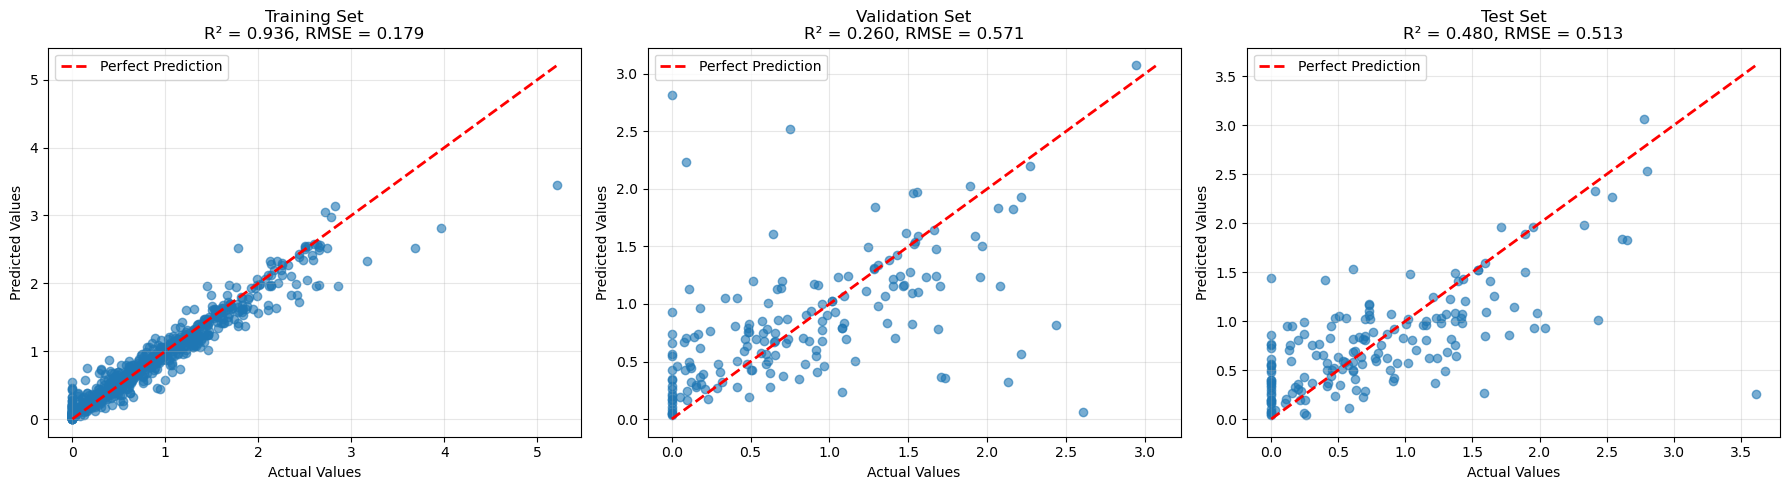

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_actual_vs_predicted(y_train, y_train_pred, axes[0], 'Training', train_metrics)
plot_actual_vs_predicted(y_val, y_val_pred, axes[1], 'Validation', val_metrics)
plot_actual_vs_predicted(y_test, y_test_pred, axes[2], 'Test', test_metrics)

plt.tight_layout()
plt.show()

Residual Plots

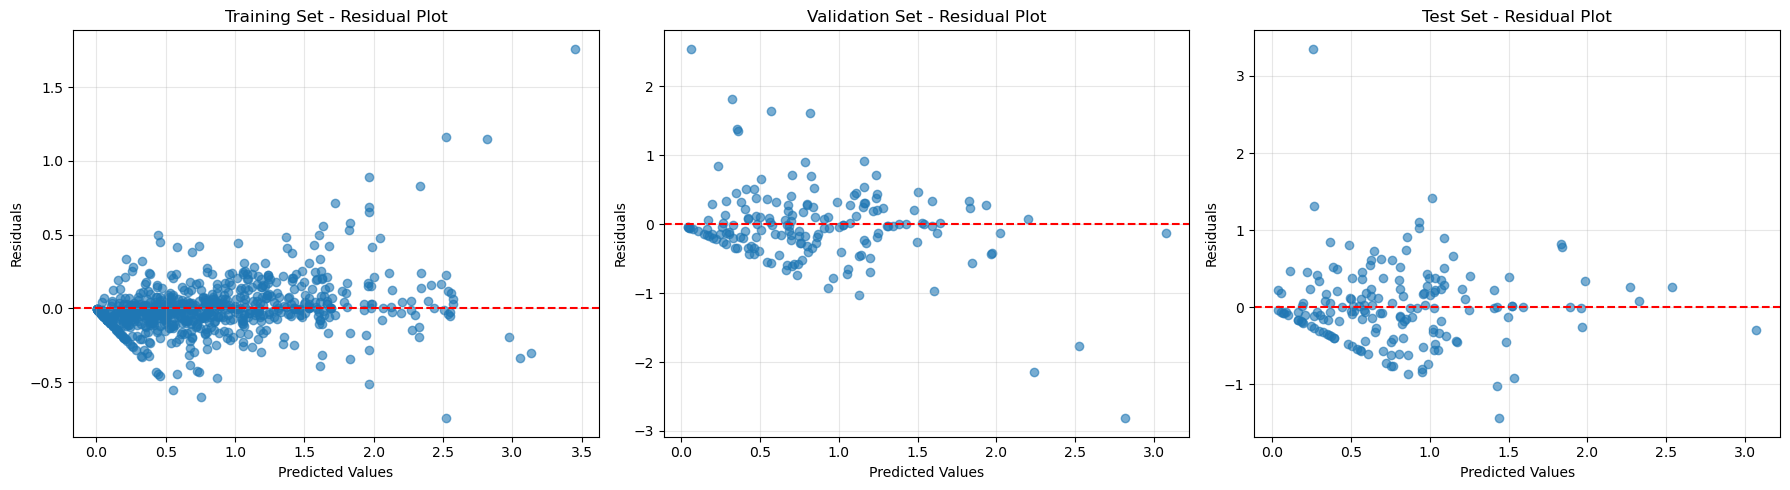

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_residuals(y_train, y_train_pred, axes[0], 'Training')
plot_residuals(y_val, y_val_pred, axes[1], 'Validation')
plot_residuals(y_test, y_test_pred, axes[2], 'Test')

plt.tight_layout()
plt.show()

#### Feature Importance Analysis

In [9]:
feature_importance, importance_df = feature_importance_analysis(best_rf, df)
importance_df

,feature,importance
47,dewpoint_c,0.040426
40,latitude,0.038675
50,feelslike_c,0.036596
23,pct_area_wetlands,0.029670
52,heatindex_c,0.029448
34,VH_Mean,0.027416
24,area_km_wetlands,0.026938
37,VH_VV_Ratio,0.026781
51,windchill_c,0.026601
39,longitude,0.025240


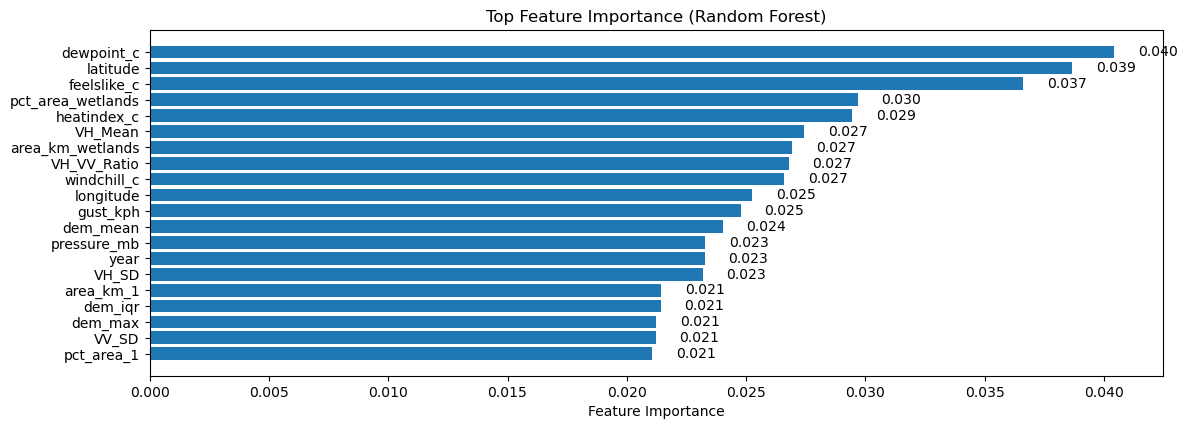

In [10]:
plot_importances(importance_df)

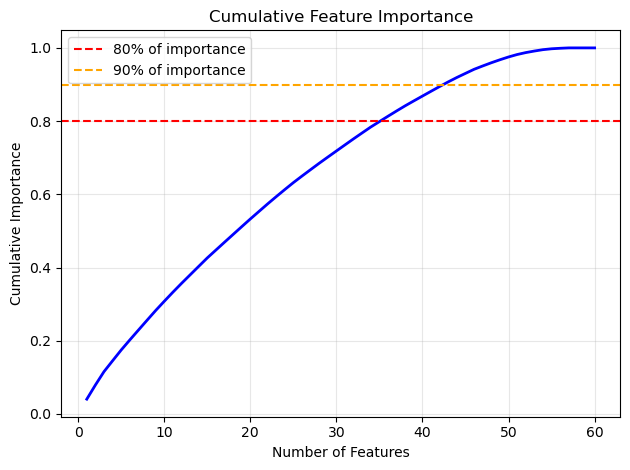

In [11]:
plot_cumulative_importances(importance_df)

In [12]:
cumulative_importance = np.cumsum(importance_df['importance'].values)
# Find number of features needed for 80% and 90% of importance
idx_80 = np.argmax(cumulative_importance >= 0.8) + 1
idx_90 = np.argmax(cumulative_importance >= 0.9) + 1

print(f"\nFeature Selection Insights:")
print(f"Number of features needed for 80% of importance: {idx_80}")
print(f"Number of features needed for 90% of importance: {idx_90}")
print(f"Total number of features: {len(feature_importance)}")

# Save feature importance to CSV
importance_path = r'data/rf_feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f"\nFeature importance saved to: {importance_path}")


Feature Selection Insights:
Number of features needed for 80% of importance: 36
Number of features needed for 90% of importance: 43
Total number of features: 60

Feature importance saved to: data/rf_feature_importance.csv


#### Model Summary

In [13]:
# Final Model Summary
print("="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
print(f"Best Random Forest Parameters: {rf_optimized.best_params_}")
print(f"Best Cross-Validation Score (neg_MSE): {rf_optimized.best_score_:.4f}")
print(f"\nFinal Test Set Performance:")
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.4f}")
print(f"  MAE: {test_metrics['mae']:.4f}")
print(f"  MSE: {test_metrics['mse']:.4f}")

# Check for overfitting
print(f"\nOverfitting Check:")
print(f"  Training R²: {train_metrics['r2']:.4f}")
print(f"  Validation R²: {val_metrics['r2']:.4f}")
print(f"  Test R²: {test_metrics['r2']:.4f}")
print(f"  Train-Val R² Gap: {train_metrics['r2'] - val_metrics['r2']:.4f}")
print(f"  Train-Test R² Gap: {train_metrics['r2'] - test_metrics['r2']:.4f}")

if train_metrics['r2'] - test_metrics['r2'] > 0.2:
    print("  WARNING: Potential overfitting detected (>20% R² gap between train and test)")
else:
    print("  Model shows good generalization")

print("\n" + "="*80)

FINAL MODEL SUMMARY
Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Cross-Validation Score (neg_MSE): -0.2875

Final Test Set Performance:
  R² Score: 0.4804
  RMSE: 0.5130
  MAE: 0.3549
  MSE: 0.2631

Overfitting Check:
  Training R²: 0.9361
  Validation R²: 0.2601
  Test R²: 0.4804
  Train-Val R² Gap: 0.6760
  Train-Test R² Gap: 0.4557



#### Extract residuals with IDs for all data splits

In [19]:
# Extract residuals with IDs for all data splits
print("="*60)
print("EXTRACTING RESIDUALS WITH IDs")
print("="*60)

# We need to reconstruct the full dataset with predictions to get residuals with IDs
# First, let's get predictions for the entire dataset
full_X = df.drop(['height_above'], axis=1).select_dtypes(include=[np.number]).values
full_y = df_wlabs['height_above'].values
original_ids = df_wlabs['ID'].values

# Standardize the full dataset using training statistics (same as used for model training)
X_mean = np.nanmean(X_train, axis=0)
X_std = np.nanstd(X_train, axis=0)
full_X_norm = (full_X - X_mean) / X_std

# Get predictions for all samples
full_predictions = best_rf.predict(full_X_norm)

# Calculate residuals (actual - predicted)
residuals = full_y - full_predictions

# Create residuals dataframe with IDs
residuals_df = pd.DataFrame({
    'ID': original_ids,
    'Actual_height_above': full_y,
    'Predicted_height_above': full_predictions,
    'Residual': residuals,
    'Absolute_Residual': np.abs(residuals)
})

# Sort by ID for easier analysis
residuals_df = residuals_df.sort_values('ID')

# Display basic statistics
print(f"Total samples: {len(residuals_df)}")
print(f"Mean residual: {residuals_df['Residual'].mean():.4f}")
print(f"Std residual: {residuals_df['Residual'].std():.4f}")
print(f"Mean absolute residual: {residuals_df['Absolute_Residual'].mean():.4f}")

# Show first few rows
print(f"\nFirst 10 rows of residuals:")
print(residuals_df.head(10))

# Save to CSV
output_path = 'data/rf_residuals.csv'
residuals_df.to_csv(output_path, index=False)
print(f"\nResiduals saved to: {output_path}")

# Additional analysis: identify largest residuals
print(f"\nTop 10 largest positive residuals (model under-predicted):")
print(residuals_df.nlargest(10, 'Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

print(f"\nTop 10 largest negative residuals (model over-predicted):")
print(residuals_df.nsmallest(10, 'Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

print(f"\nTop 10 largest absolute residuals:")
print(residuals_df.nlargest(10, 'Absolute_Residual')[['ID', 'Actual_height_above', 'Predicted_height_above', 'Residual']])

EXTRACTING RESIDUALS WITH IDs
Total samples: 1147
Mean residual: -0.0009
Std residual: 0.3332
Mean absolute residual: 0.1838

First 10 rows of residuals:
       ID  Actual_height_above  Predicted_height_above  Residual  \
966   770             1.539240                1.533954  0.005286   
1020  771             1.690624                1.689388  0.001236   
560   772             1.690624                1.688226  0.002398   
1126  773             1.539240                1.524582  0.014658   
102   774             1.539240                1.524582  0.014658   
711   775             1.539240                1.533954  0.005286   
572   776             1.690624                1.688226  0.002398   
468   777             1.690624                1.689388  0.001236   
352   778             1.539240                1.524582  0.014658   
1022  779             1.539240                1.524582  0.014658   

      Absolute_Residual  
966            0.005286  
1020           0.001236  
560            0.00

/tmp/ipykernel_4153898/3487678392.py:15: RuntimeWarning: invalid value encountered in divide
  full_X_norm = (full_X - X_mean) / X_std


### Contributors
- Parnian Ghaneei
- Xiao Chen
- Jinkun Liu
- Temitope Akinboyewa
- Rufai Omowunmi Balogun
- Aleksander Berg
- Wen Zhou, PhD.